### Task description

We ask you to implement a flow-based model called **Inverse Autoregressive Flow** (https://arxiv.org/abs/1606.04934) to fit a simple 2-dimensional **Gaussian Mixture Model** density. Note that although the paper uses the flow to better approximate the posterior distribution of a VAE, we **do not ask you** to implement the whole VAE in this task. Instead, use the IAF directly for density estimation.

A few notes on the implementation:

* The most important thing in the implementation is a choice of architecture of the autoregressive model. Since we're only dealing with sequences of length 2, using MADE as in the original paper is not necessary. In fact, since the input vector is only two-dimensional, its first component is always transformed by a fixed linear operation. So only the dependency between the second and the first component is to be modeled. This dependency can be modeled by any feedforward network capable of transforming one scalar value into another. We have found a simple dense->relu->dense->... model (with hidden layers having 16 neurons) to work. Adding batch normalization to this network seems to hurt the performance.

* You might need several IAF steps in order to fit the target density. We have found that including an invertible batch normalization step (implementation included) between the AR steps assists convergence (unlike batch normalization **within** the "autoregressive step" mentioned above). We have found the optimal number of steps to be around 10, where each step uses the same network architecture described above (parameters are not shared between steps). It's important to flip the components of the vector at each IAF step to avoid trivial transformations.

* Note that the IAF formulation implies parallel sampling (i.e. parallel $\mathbf{z} \to \mathbf{x}$ mapping) but autoregressive density estimation (i.e. autoregressive $\mathbf{x} \to \mathbf{z}$ mapping).

* Add visualisations/logging of your choice to demonstrate the learning process.

* We do not constrain you in terms of tools, but we except you to use either PyTorch or Tensorflow as the main deep learning framework. Note that you will have to reimplement some of our starter code in Tensorflow (including the invertible batch norm) should you wish to use Tensorflow.

Please find the starter code below. We provide all the code required to run the training except for the *IAFStep* class which you are to implement. Do not worry about the validation performance; for this task we only care about convergence.

Good luck!

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.mixture import GaussianMixture
from sklearn.mixture._gaussian_mixture import _compute_precision_cholesky # fix import

import random
import os

In [2]:
def set_seed(seed):

    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [3]:
set_seed(1411)

In [4]:
n_components = 4

means = [
    [3.0, 3.0],
    [3.0, -3.0],
    [-3.0, 3.0],
    [-3.0, -3.0],
]

covs = [
    [0.1, 0.1],
    [0.05, 0.05],
    [0.05, 0.05],
    [0.1, 0.1],
]

weights = [
    0.25,
    0.25,
    0.25,
    0.25
]

In [5]:
gmm = GaussianMixture(covariance_type="diag", n_components=n_components)

gmm.weights_ = np.array(weights)
gmm.means_ = np.array(means)
gmm.covariances_ = np.array(covs)
gmm.precisions_cholesky_ = _compute_precision_cholesky(gmm.covariances_, gmm.covariance_type)
# for 'diag' covariance type, precisions_cholesky_ is 1 / sqrt(covariances_)
# gmm.precisions_cholesky_ = 1. / np.sqrt(gmm.covariances_)

In [6]:
def make_samples(n):
    samples, labels = gmm.sample(n)
    return samples.astype(np.float32)

def plot_samples(samples, limits=(-10, 10), filename=None, title=None):

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.scatter(samples[:, 0], samples[:, 1], alpha=0.2, s=10, c="green")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    if title is not None:
        ax.set_title(title, fontsize=16)

    if limits is not None:
        ax.set_xlim(*limits)
        ax.set_ylim(*limits)
    
    if filename is not None:
        plt.savefig(filename, dpi=300)
        plt.close(fig)
    else:
        plt.show()

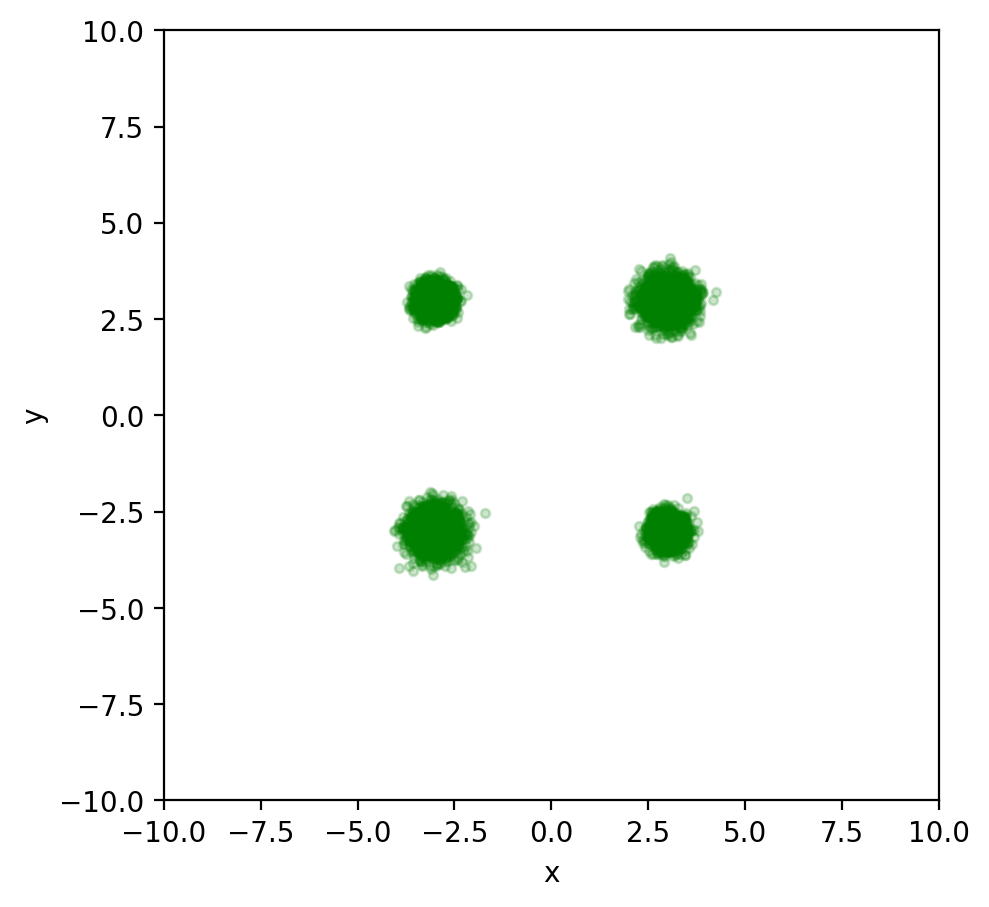

In [7]:
plot_samples(make_samples(10000))

In [ ]:
class IAFStep(torch.nn.Module):

    def __init__(self, flip=False):
        """
        Args:
            flip (bool): if True, the input components are flipped before processing.
        """
        super().__init__()

        self.flip = flip
        self.ar_net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2) # outputs m_2 and s_2
        )

        self.m1_param = nn.Parameter(torch.randn(1))

        # initialize s1_param to 1.0 for a stable start, mentioned in the paper 
        self.s1_param = nn.Parameter(torch.full((1,), 1.0))

        # initialize the output layer of the ar_net similarly
        # this helps a lot in case we don't use the batchnorm, otherwise it is not necessary
         
        #nn.init.constant_(self.ar_net[-1].bias[0], 0.0) # m2 bias
        #nn.init.constant_(self.ar_net[-1].bias[1], 1.0) # s2 bias
        #nn.init.zeros_(self.ar_net[-1].weight)


    def forward(self, x):
        """
        Args:
            x: The input tensor from the base distribution. Shape (B, 2).

        Returns:
            The transformed tensor y. Shape (B, 2).
        """
        
        _x = x
        if self.flip:
            _x = _x.flip(dims=(1,))

        x1, x2 = _x[:, 0:1], _x[:, 1:2] # (B, 1) each

        m1 = self.m1_param.expand_as(x1)
        s1 = self.s1_param.expand_as(x1)
        
        ms2 = self.ar_net(x1)
        m2, s2 = ms2[:, 0:1], ms2[:, 1:2]

        m = torch.cat([m1, m2], dim=1) # (B, 2)
        s = torch.cat([s1, s2], dim=1) # (B, 2)

        self.s_cache = s

        sigma = torch.sigmoid(s)
        y = sigma * _x + (1 - sigma) * m # Eq. (14) 

        if self.flip:
            y = y.flip(dims=(1,))

        return y
        
    def reverse(self, y):
        """
        Args:
            y: The input tensor from the data distribution. Shape (B, 2).

        Returns:
            The transformed tensor x. Shape (B, 2).
        """

        _y = y
        if self.flip:
            _y = _y.flip(dims=(1,))

        y1, y2 = _y[:, 0:1], _y[:, 1:2] # (B, 1) each

        m1 = self.m1_param.expand_as(y1)
        s1 = self.s1_param.expand_as(y1)
        sigma1 = torch.sigmoid(s1)
        x1 = (y1 - (1 - sigma1) * m1) / sigma1 # Invert Eq. (14)
        
        ms2 = self.ar_net(x1)
        m2, s2 = ms2[:, 0:1], ms2[:, 1:2]
        sigma2 = torch.sigmoid(s2)
        x2 = (y2 - (1 - sigma2) * m2) / sigma2 # Invert Eq. (14)

        x_base = torch.cat([x1, x2], dim=1) # (B, 2)

        self.s_cache = torch.cat([s1, s2], dim=1)

        if self.flip:
            x_base = x_base.flip(dims=(1,))
            
        return x_base
                       
    def log_determinant(self, x=None, y=None):
        """
        Args:
            x: The tensor from the base distribution. Shape (B, 2).
            y: The tensor from the data distribution. Shape (B, 2).

        Returns:
            The log-determinant for each item in the batch. Shape (B,).
        """

        if y is not None:

            self.reverse(y)

        elif x is not None:

            self(x) # self(x) calls self.forward(x)

        log_sigma = F.logsigmoid(self.s_cache) # Shape (B, 2)
        
        # we return the log-det per-sample (sum over dimensions)
        # the outer TransformedDistribution.logprob will handle the batch mean
        return log_sigma.sum(dim=1) # (B,)

In [9]:
class BatchNorm(torch.nn.Module):
    # Invertible batch normalization implementation.
    # Just like a usual BatchNorm, but has the reverse method.

    def __init__(self, momentum=0.9, eps=1e-5):
        super().__init__()

        self.log_gamma = torch.nn.Parameter(torch.zeros(2))
        self.beta = torch.nn.Parameter(torch.zeros(2))
        self.momentum = momentum
        self.eps = eps

        self.register_buffer("running_mean", torch.zeros(2))
        self.register_buffer("running_var", torch.ones(2))

    def reverse(self, y):

        if self.training:
            self.batch_mean = y.mean(0)
            self.batch_var = (
                y - self.batch_mean).pow(2).mean(0) + self.eps

            self.running_mean.mul_(self.momentum)
            self.running_var.mul_(self.momentum)

            self.running_mean.add_(self.batch_mean.data *
                                   (1 - self.momentum))
            self.running_var.add_(self.batch_var.data *
                                  (1 - self.momentum))

            mean = self.batch_mean
            var = self.batch_var
        else:
            mean = self.running_mean
            var = self.running_var

        self.var = var   # cache this for log_determinant()

        x = (y - mean) / var.sqrt()
        x = torch.exp(self.log_gamma) * x + self.beta
        return x
        
    def forward(self, x):
        if self.training:
            mean = self.batch_mean
            var = self.batch_var
        else:
            mean = self.running_mean
            var = self.running_var
            
        self.var = var

        y = (x - self.beta) / torch.exp(self.log_gamma)
        y = y * var.sqrt() + mean
        return y
    
    def log_determinant(self, x=None, y=None):
        if x is not None:
            self(x)
        elif y is not None:
            self.reverse(y)
        
        return -(self.log_gamma - 0.5 * torch.log(self.var)).sum(-1) #.mean() is redundant, since the value is a scalar after .sum(-1)

In [10]:
class TransformedDistribution(torch.nn.Module):
    # The class takes a base distribution and a list of invertible transforms.
    # It implements logprob and sampling methods required for training/generation.

    def __init__(self, base_distribution, transforms):
        super().__init__()
        self.base_distribution = base_distribution
        self.transforms = torch.nn.ModuleList(transforms)

    def sample(self, n):
        # sample a batch of size n from the distribution
        self.eval()
        with torch.no_grad():
            z = self.base_distribution.sample(n)
            for transform in self.transforms:
                z = transform(z)
            return z
    
    def sample_hierarcical(self, n):
        # works in the same way as sample(),
        # but returns z from all transformation steps
        self.eval()
        with torch.no_grad():
            z = self.base_distribution.sample(n)
            zs = [z]
            for transform in self.transforms:
                z = transform(z)
                zs.append(z)
            return zs

    def logprob(self, x):
        # compute the log probability of given datapoints
        # by iteratively transforming x to z and using
        # the change of variables rule 
        
        self.train()

        y = x

        logprob = 0.0

        for transform in reversed(self.transforms):
            x = transform.reverse(y)
            logprob = logprob - transform.log_determinant()
            y = x

        logprob = logprob + self.base_distribution.logprob(y)

        return logprob.mean() # ensure scalar output

In [11]:
class StandardNormalDistribution(torch.nn.Module):

    def __init__(self, sample_shape):
        super().__init__()

        self.sample_shape = sample_shape

    def sample(self, n):
        with torch.no_grad():
            z = torch.zeros(n, *self.sample_shape).normal_()
            return z

    def logprob(self, x):

        #n = x.size(0)
        #return (-(x ** 2) / 2 - math.log(math.sqrt(2 * math.pi))).sum() / n
        # returns a scalar. This eventually broadcasts the scalar inside of TransformedDistribution.logprob()

        return (-(x ** 2) / 2 - 0.5 * math.log(2 * math.pi)).sum(dim=1) # (B,)

In [12]:
layers = 12

transforms = []
for k in range(layers):
    transforms.append(IAFStep(flip=(k % 2 == 1)))   # flip IAF steps, as suggested in the paper and task description
    transforms.append(BatchNorm())

base = StandardNormalDistribution(sample_shape=(2,))
transformed_distribution = TransformedDistribution(base, transforms)

optimizer = torch.optim.AdamW(
    transformed_distribution.parameters(), lr=5e-3, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9998)

In [13]:
def train(distribution, optimizer, scheduler, steps, batch_size, log_interval=50):

    frames_dir = "training_frames"
    os.makedirs(frames_dir, exist_ok=True)

    for step in range(steps):
        
        distribution.train()
        
        data = torch.from_numpy(make_samples(batch_size))

        optimizer.zero_grad()
        logprob = distribution.logprob(data)
        loss = -logprob
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step % log_interval == 0:
            loss_value = loss.item()
            print(f"Step: {step:<6} | Loss: {loss_value:.4f}")
            
            samples = distribution.sample(10000).data.numpy()
            
            filename = f"{frames_dir}/frame_{step:06d}.png"
            title = f"Step: {step} | Loss: {loss_value:.4f}"
            
            plot_samples(samples, limits=(-10, 10), filename=filename, title=title)

In [14]:
# again, feel free to change the training parameters

trace = train(
    transformed_distribution,
    optimizer,
    scheduler,
    steps=10100,      
    batch_size=2048,
    log_interval=100,
)

Step: 0      | Loss: 5.9500
Step: 100    | Loss: 2.8956
Step: 200    | Loss: 1.9365
Step: 300    | Loss: 1.8336
Step: 400    | Loss: 1.8326
Step: 500    | Loss: 1.7774
Step: 600    | Loss: 1.7613
Step: 700    | Loss: 1.9154
Step: 800    | Loss: 1.7879
Step: 900    | Loss: 1.8098
Step: 1000   | Loss: 1.7626
Step: 1100   | Loss: 1.7056
Step: 1200   | Loss: 1.6970
Step: 1300   | Loss: 1.7182
Step: 1400   | Loss: 1.6730
Step: 1500   | Loss: 1.6895
Step: 1600   | Loss: 1.6347
Step: 1700   | Loss: 1.7193
Step: 1800   | Loss: 1.7803
Step: 1900   | Loss: 1.6776
Step: 2000   | Loss: 1.6451
Step: 2100   | Loss: 1.6670
Step: 2200   | Loss: 1.6423
Step: 2300   | Loss: 1.7574
Step: 2400   | Loss: 1.6428
Step: 2500   | Loss: 1.6480
Step: 2600   | Loss: 1.6703
Step: 2700   | Loss: 1.6727
Step: 2800   | Loss: 1.6885
Step: 2900   | Loss: 1.6600
Step: 3000   | Loss: 1.6186
Step: 3100   | Loss: 1.6275
Step: 3200   | Loss: 1.6627
Step: 3300   | Loss: 1.6534
Step: 3400   | Loss: 1.7702
Step: 3500   | Loss: